# Flora MobileNet V3 Large Model with modefied weights for fine-tuning

### 1. Import Libraries

In [18]:
# General purposes and essentials
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image
import cv2

# pytorch
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast, GradScaler

# torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchvision.models.feature_extraction import create_feature_extractor

# sklearn
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc, average_precision_score
from sklearn.preprocessing import label_binarize

# seaborn
import seaborn as sns

### 2. Load Dataset

In [2]:
data_dir = './dataset'

### 3. Set Configurations

In [3]:
model_path = '../../saved_models/flora/flora_model.pt'
tscript_path = '../../saved_models/flora/scripted/flora_model.pt'
temp_model_path = os.path.join(os.path.dirname(model_path), "flora_model_temp.pt")

batch_size = 16
num_epochs = 15
num_classes = 105

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 4. Data Transforms and Dataset Setup

In [4]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

dataset = ImageFolder(root=data_dir, transform=transform)
class_names = dataset.classes
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

print("✅ Classes:", class_names)

✅ Classes: ['alpine_sea_holly', 'anthurium', 'artichoke', 'azalea', 'ball_moss', 'balloon_flower', 'barbeton_daisy', 'bearded_iris', 'bee_balm', 'bird_of_paradise', 'bishop_of_llandaff', 'black-eyed_susan', 'blackberry_lily', 'blanket_flower', 'bolero_deep_blue', 'bougainvillea', 'bromelia', 'buttercup', 'californian_poppy', 'camellia', 'canna_lily', 'canterbury_bells', 'cape_flower', 'carnation', 'cautleya_spicata', 'clematis', "colt's_foot", 'columbine', 'common_dandelion', 'corn_poppy', 'cyclamen', 'daffodil', 'daisy', 'dandelion', 'desert-rose', 'english_marigold', 'fire_lily', 'foxglove', 'frangipani', 'fritillary', 'garden_phlox', 'gaura', 'gazania', 'geranium', 'giant_white_arum_lily', 'globe-flower', 'globe_thistle', 'grape_hyacinth', 'great_masterwort', 'hard-leaved_pocket_orchid', 'hibiscus', 'hippeastrum', 'japanese_anemone', 'king_protea', 'lenten_rose', 'lotus', 'love_in_the_mist', 'magnolia', 'mallow', 'marigold', 'mexican_aster', 'mexican_petunia', 'monkshood', 'moon_orc

### 5. Load Model and Modify Classifier

In [5]:
model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)

# Freeze all layers
for param in model.features.parameters():
    param.requires_grad = False

# Unfreeze last few blocks for fine-tuning
for name, param in model.features.named_parameters():
    if "7" in name or "8" in name or "9" in name:
        param.requires_grad = True

# Replace final classifier layer
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
model = model.to(device)

### 6. Define Loss, Optimizer & Tracking Lists

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
scaler = GradScaler(device=device)

train_loss_history, val_loss_history = [], []
train_acc_history, val_acc_history = [], []

best_val_acc = 0.0
early_stop_counter = 0
early_stop_patience = 5

### 7. Extended Evaluation and Visualization

In [17]:
# 🧩 Confusion Matrix + Report + Per-Class Accuracy
def evaluate_model(model, data_loader, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    num_classes = len(class_names)
    figsize = (min(max(12, num_classes * 0.2), 40), min(max(10, num_classes * 0.2), 40))
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xticks(rotation=90, fontsize=6)
    plt.yticks(rotation=0, fontsize=6)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Report
    print("📋 Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Per-class Accuracy
    acc_per_class = cm.diagonal() / cm.sum(axis=1)
    for cls, acc in zip(class_names, acc_per_class):
        print(f"🔹 {cls}: {acc*100:.2f}%")

# 🧠 Paginated Misclassified Images Viewer
def show_misclassified_images(model, data_loader, class_names, transform, page=1, images_per_page=12):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if preds[i] != labels[i]:
                    misclassified.append((images[i].cpu(), preds[i].cpu(), labels[i].cpu()))

    total = len(misclassified)
    if total == 0:
        print("✅ No misclassified images found!")
        return

    # Pagination
    total_pages = (total + images_per_page - 1) // images_per_page
    page = max(1, min(page, total_pages))
    start = (page - 1) * images_per_page
    end = start + images_per_page
    current_batch = misclassified[start:end]

    # Plot
    rows = (len(current_batch) + 3) // 4
    plt.figure(figsize=(15, 4 * rows))
    for i, (img, pred, true) in enumerate(current_batch):
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        plt.subplot(rows, 4, i + 1)
        plt.imshow(img)
        plt.title(f'P: {class_names[pred]}\nT: {class_names[true]}', fontsize=9)
        plt.axis('off')
    plt.suptitle(f"❌ Misclassified Images (Page {page} / {total_pages})", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print(f"📄 Showing page {page} of {total_pages} — {total} misclassified images total.")


# 📉 Multi-Class ROC Curve
def plot_roc_curve(model, data_loader, class_names, top_k=20):
    model.eval()
    y_true, y_probs = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            y_probs.append(probs)
            y_true.append(labels.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_probs = np.concatenate(y_probs)
    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

    roc_aucs = []
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        roc_aucs.append((i, fpr, tpr, roc_auc))

    # Sort and keep top_k
    roc_aucs.sort(key=lambda x: x[3], reverse=True)
    plt.figure(figsize=(min(20, 2 + 0.15 * top_k), 10))
    for i, fpr, tpr, roc_auc in roc_aucs[:top_k]:
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Top {top_k} Multi-class ROC Curve')
    plt.legend(fontsize='x-small', ncol=2)
    plt.grid()
    plt.tight_layout()
    plt.show()

# 📊 Precision-Recall Curve
def plot_precision_recall_curve(model, data_loader, class_names, top_k=20):
    model.eval()
    y_true, y_probs = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            y_probs.append(probs)
            y_true.append(labels.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_probs = np.concatenate(y_probs)
    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

    ap_scores = []
    for i in range(len(class_names)):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
        ap = average_precision_score(y_true_bin[:, i], y_probs[:, i])
        ap_scores.append((i, precision, recall, ap))

    ap_scores.sort(key=lambda x: x[3], reverse=True)
    plt.figure(figsize=(min(20, 2 + 0.15 * top_k), 10))
    for i, precision, recall, ap in ap_scores[:top_k]:
        plt.plot(recall, precision, label=f'{class_names[i]} (AP = {ap:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Top {top_k} Precision-Recall Curve')
    plt.legend(fontsize='x-small', ncol=2)
    plt.grid()
    plt.tight_layout()
    plt.show()

# 🔥 Grad-CAM for Model Explainability
def show_gradcam(model, image_path, class_names, target_layer="features.16"):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    feature_extractor = create_feature_extractor(model, return_nodes={target_layer: "feat"})
    features, grads = [], []

    def forward_hook(module, input, output):
        features.append(output)

    def backward_hook(module, grad_in, grad_out):
        grads.append(grad_out[0])

    handle_feat = model.features[16].register_forward_hook(forward_hook)
    handle_grad = model.features[16].register_backward_hook(backward_hook)

    output = model(input_tensor)
    class_idx = torch.argmax(output, dim=1).item()
    model.zero_grad()
    output[0, class_idx].backward()

    fmap = features[0][0].detach().cpu().numpy()
    grad = grads[0][0].detach().cpu().numpy()
    weights = grad.mean(axis=(1, 2))
    cam = np.zeros(fmap.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * fmap[i]
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam -= cam.min()
    cam /= cam.max()
    cam = np.uint8(255 * cam)


    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    original = cv2.cvtColor(np.array(image.resize((224, 224))), cv2.COLOR_RGB2BGR)
    overlay = cv2.addWeighted(original, 0.5, heatmap, 0.5, 0)

    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM: {class_names[class_idx]}")
    plt.axis('off')
    plt.show()

    handle_feat.remove()
    handle_grad.remove()

### 8. Training and Validation Loop with Automatic Mixed Precision (AMP)

In [8]:
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type='cpu'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Save best to temp
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stop_counter = 0
        torch.save(model.state_dict(), temp_model_path)
        print(f"🔸 Improved! Temp model saved with Val Acc: {val_acc:.4f}")
    else:
        early_stop_counter += 1
        print(f"⚠️  No improvement. Early stop counter: {early_stop_counter}/{early_stop_patience}")

        if early_stop_counter >= early_stop_patience:
            print("🛑 Early stopping triggered!")
            break

Epoch 1/15 | Train Loss: 1.8856, Acc: 0.5675 | Val Loss: 0.8436, Acc: 0.7690
🔸 Improved! Temp model saved with Val Acc: 0.7690
Epoch 2/15 | Train Loss: 0.7925, Acc: 0.7807 | Val Loss: 0.6186, Acc: 0.8195
🔸 Improved! Temp model saved with Val Acc: 0.8195
Epoch 3/15 | Train Loss: 0.6003, Acc: 0.8285 | Val Loss: 0.5728, Acc: 0.8351
🔸 Improved! Temp model saved with Val Acc: 0.8351
Epoch 4/15 | Train Loss: 0.4688, Acc: 0.8679 | Val Loss: 0.4178, Acc: 0.8835
🔸 Improved! Temp model saved with Val Acc: 0.8835
Epoch 5/15 | Train Loss: 0.4408, Acc: 0.8787 | Val Loss: 0.4396, Acc: 0.8757
⚠️  No improvement. Early stop counter: 1/5
Epoch 6/15 | Train Loss: 0.4234, Acc: 0.8764 | Val Loss: 0.4172, Acc: 0.8798
⚠️  No improvement. Early stop counter: 2/5
Epoch 7/15 | Train Loss: 0.3937, Acc: 0.8908 | Val Loss: 0.4311, Acc: 0.8819
⚠️  No improvement. Early stop counter: 3/5
Epoch 8/15 | Train Loss: 0.3990, Acc: 0.8881 | Val Loss: 0.3947, Acc: 0.8970
🔸 Improved! Temp model saved with Val Acc: 0.8970
Ep

### 8.5. Evaluate and Visualize Results on Validation Set

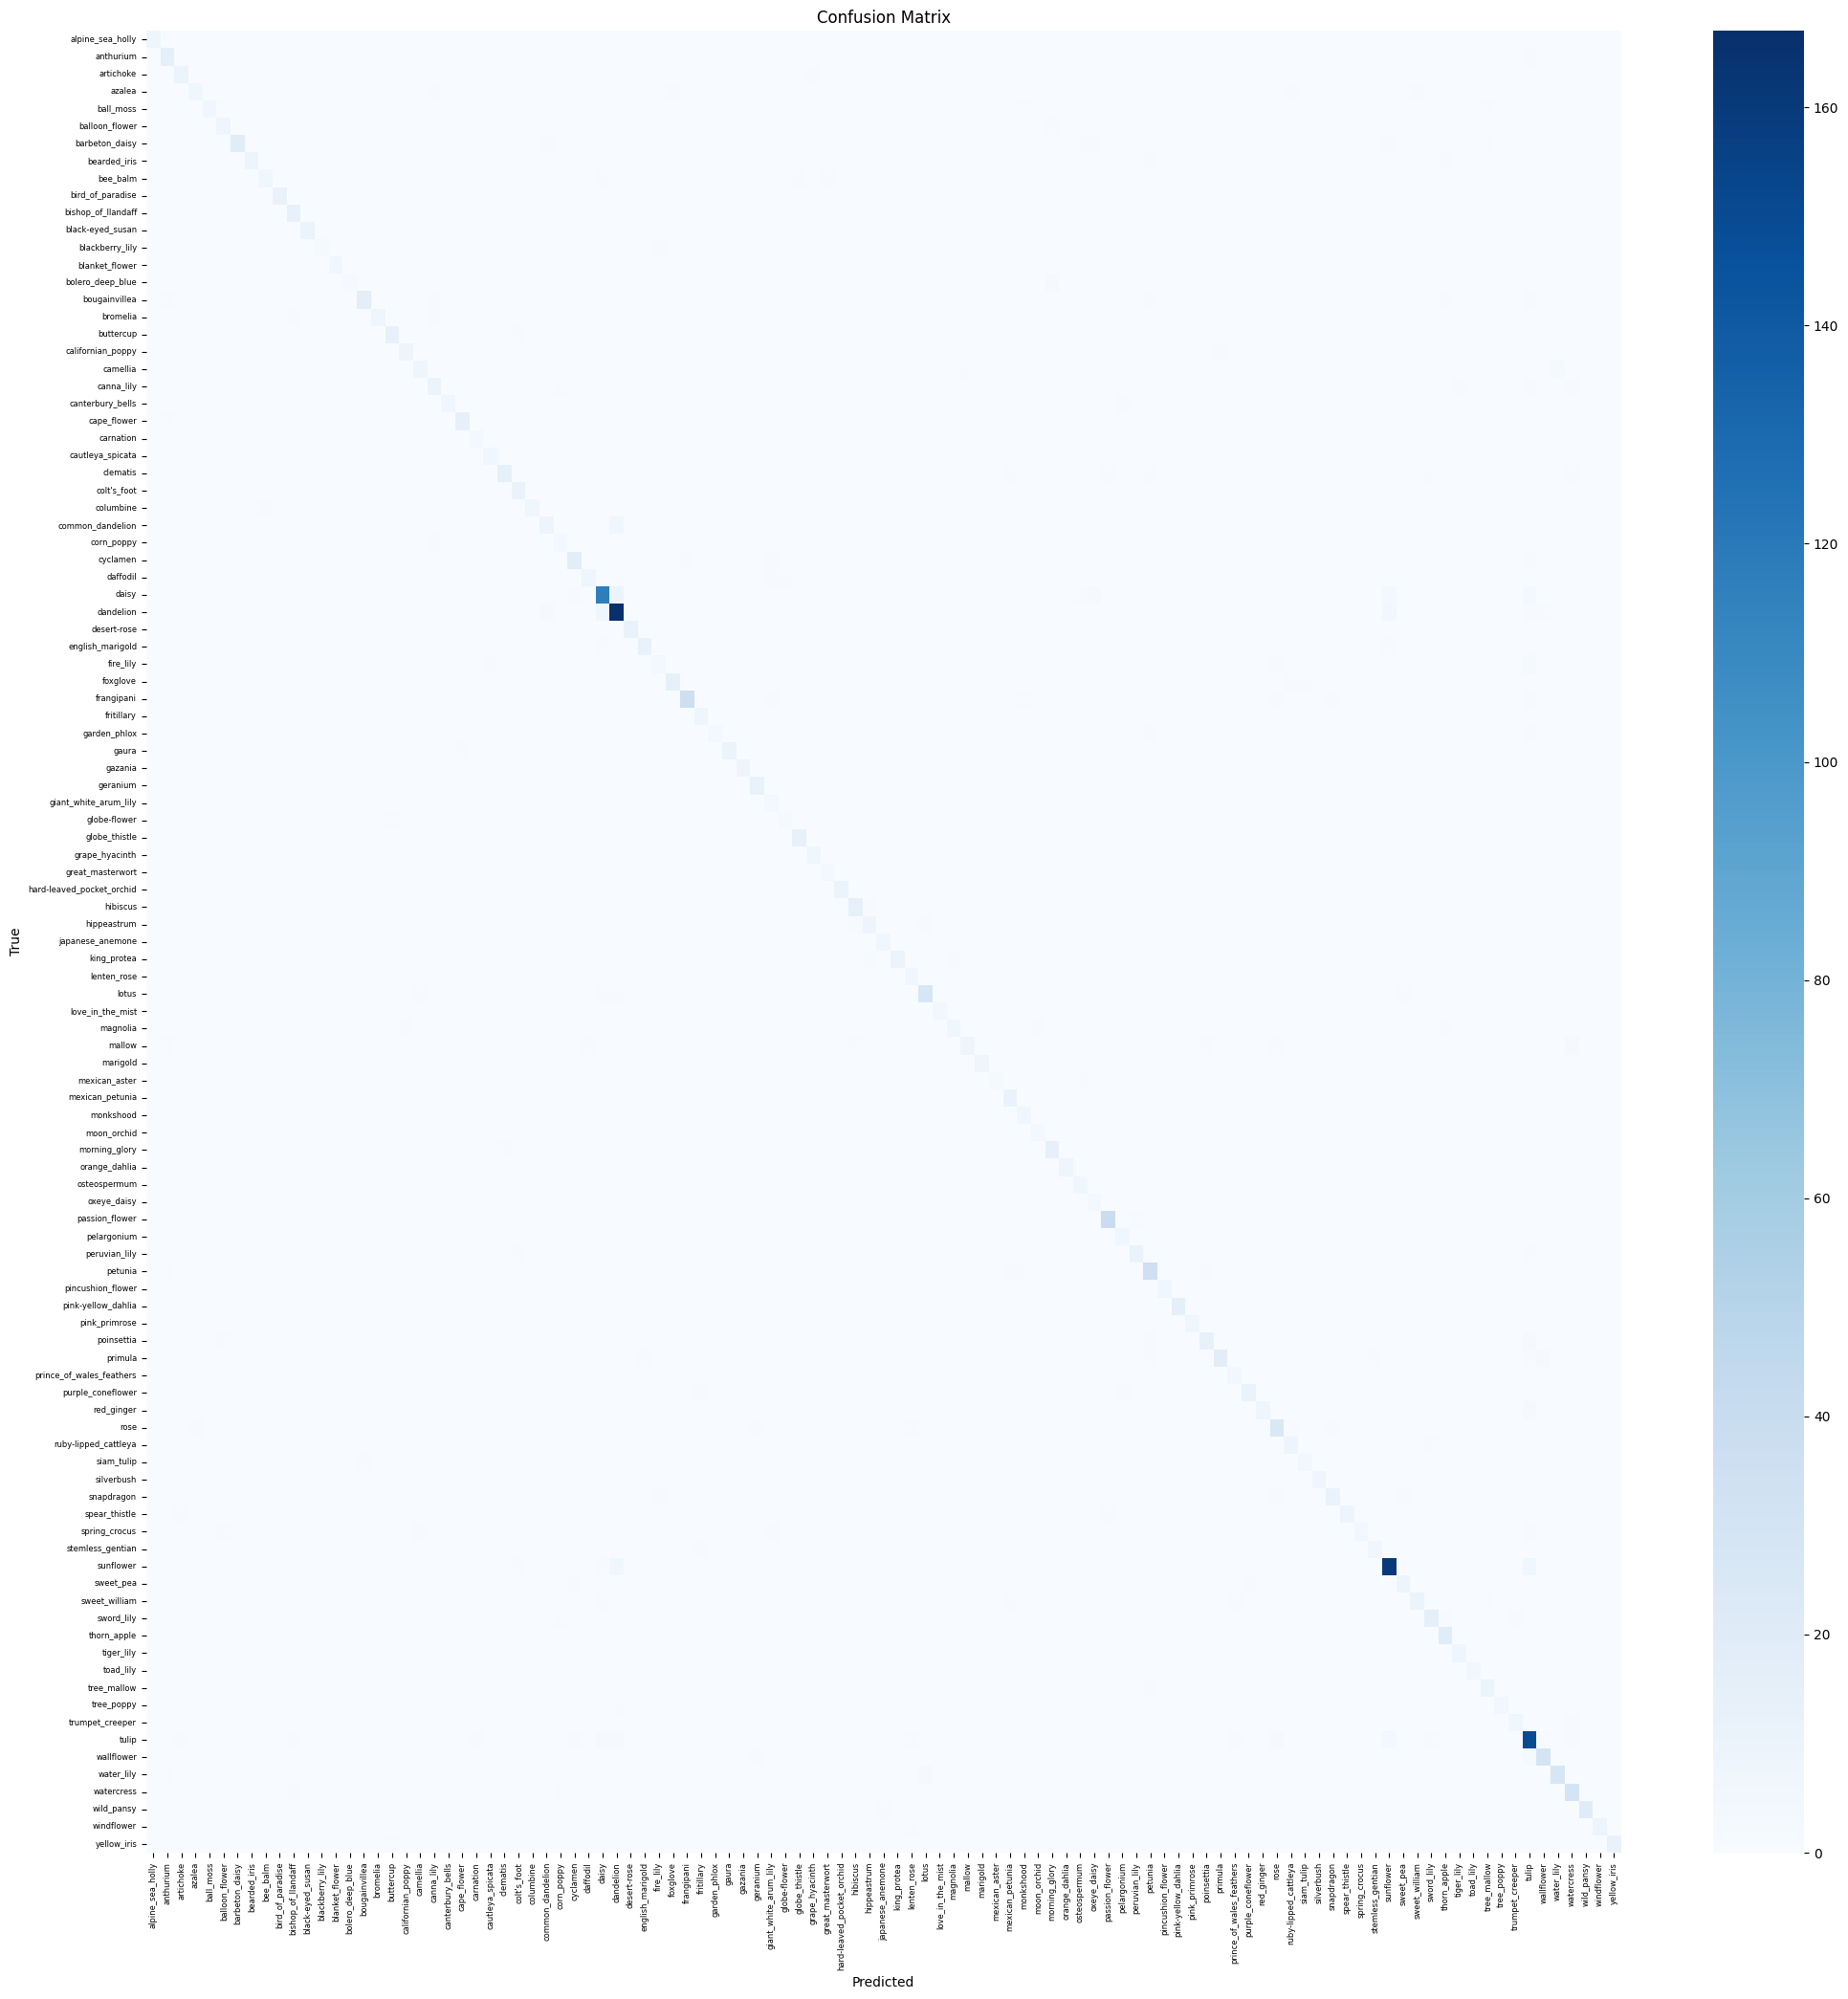

📋 Classification Report:

                           precision    recall  f1-score   support

         alpine_sea_holly       1.00      1.00      1.00         8
                anthurium       0.76      0.94      0.84        17
                artichoke       0.83      0.91      0.87        11
                   azalea       0.88      0.64      0.74        11
                ball_moss       1.00      0.75      0.86         8
           balloon_flower       0.80      0.89      0.84         9
           barbeton_daisy       1.00      0.79      0.88        24
             bearded_iris       1.00      0.82      0.90        11
                 bee_balm       0.88      0.70      0.78        10
         bird_of_paradise       1.00      1.00      1.00        12
       bishop_of_llandaff       0.81      1.00      0.90        13
         black-eyed_susan       1.00      1.00      1.00        10
          blackberry_lily       1.00      0.75      0.86         4
           blanket_flower       1.0

C:\Users\bhuva\AppData\Local\Temp\ipykernel_25992\1748011826.py:77: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
d:\Project_naveen\PW\project_chimera\classifier_service\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


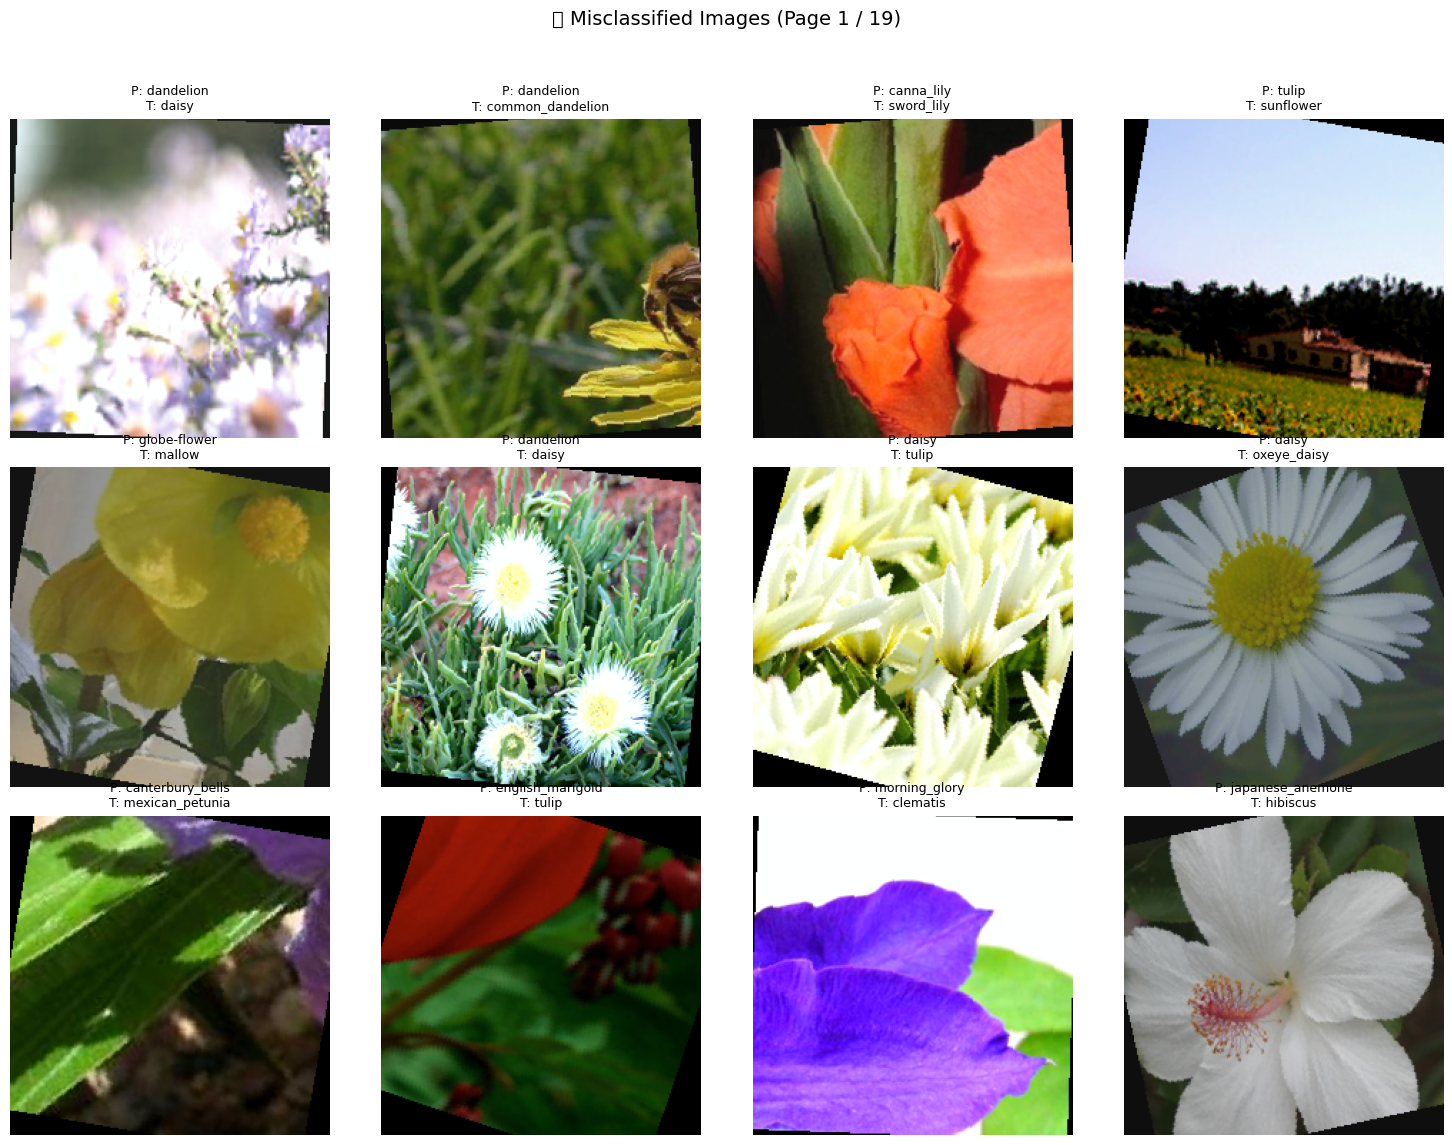

📄 Showing page 1 of 19 — 227 misclassified images total.


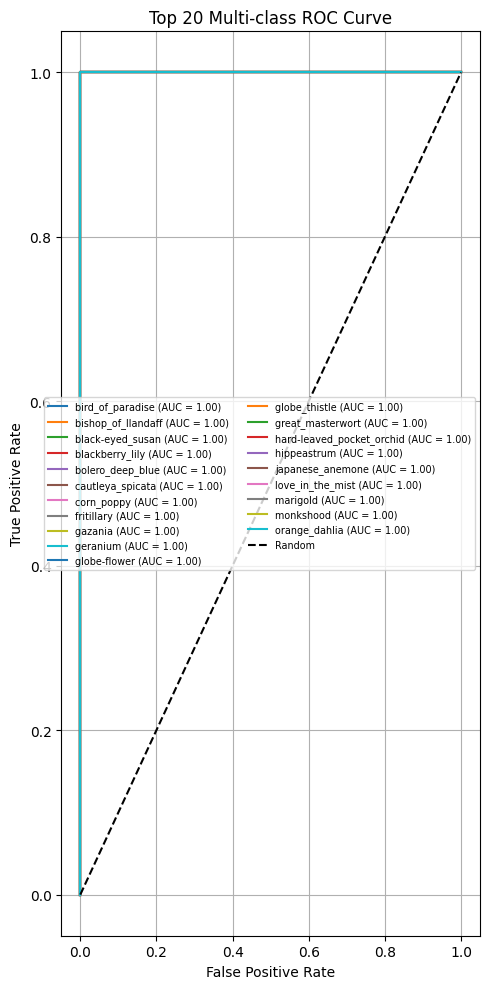

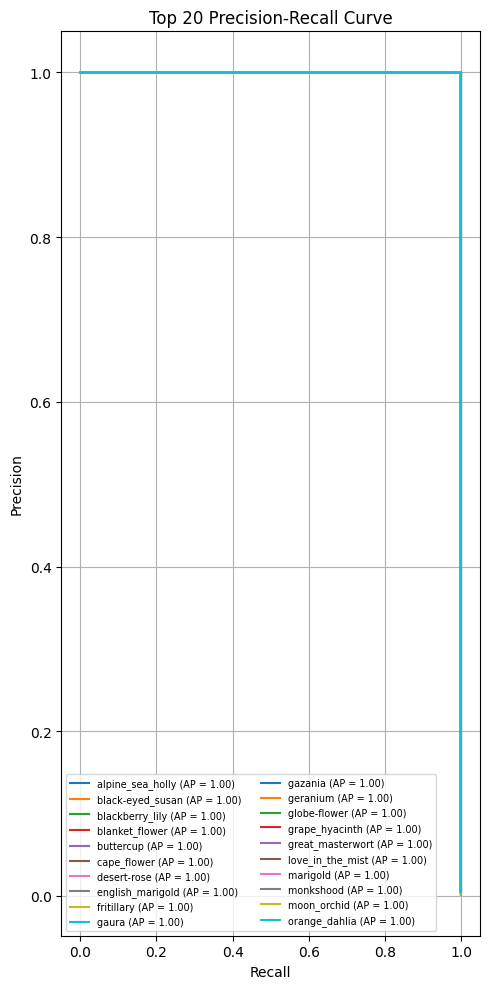

d:\Project_naveen\PW\project_chimera\classifier_service\.venv\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


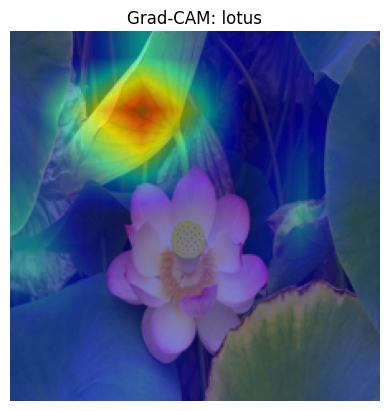

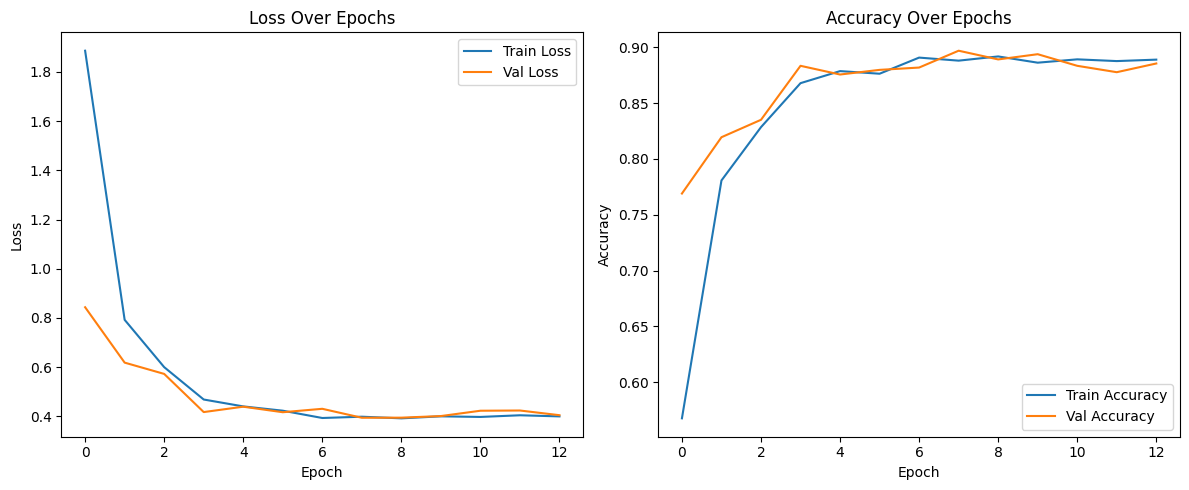

In [20]:
# Evaluate full model
evaluate_model(model, val_loader, class_names)

# Show misclassified images
show_misclassified_images(model, val_loader, class_names, transform)

# ROC & PR Curves
plot_roc_curve(model, val_loader, class_names)
plot_precision_recall_curve(model, val_loader, class_names)

# Grad-CAM for a specific image (you can change the image path)
show_gradcam(model, './test_image.jpg', class_names)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


### 9. Save Trained Final Model

In [12]:
if os.path.exists(temp_model_path):
    model_dir = os.path.dirname(model_path)
    existing_models = [f for f in os.listdir(model_dir) if f.startswith("flora_model_v") and f.endswith(".pt")]
    version_numbers = [int(f.split("_v")[-1].split(".pt")[0]) for f in existing_models if "_v" in f]
    next_version = max(version_numbers) + 1 if version_numbers else 1
    versioned_model_path = os.path.join(model_dir, f"flora_model_v{next_version}.pt")

    os.rename(temp_model_path, versioned_model_path)
    print(f"✅ Final model saved as versioned model: {versioned_model_path}")

✅ Final model saved as versioned model: ../../saved_models/flora\flora_model_v3.pt


### 9.5 Generate Evaluation Report

In [19]:
def generate_evaluation_report(model, val_loader, class_names, transform, train_loss_history, val_loss_history, train_acc_history, val_acc_history, version_number):
    report_dir = "report"
    os.makedirs(report_dir, exist_ok=True)
    pdf_path = os.path.join(report_dir, f"report_of_{version_number}.pdf")

    model.eval()
    all_preds, all_labels = [], []
    y_probs, y_true_bin = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            y_probs.append(probs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            y_true_bin.append(label_binarize(labels.cpu().numpy(), classes=np.arange(len(class_names))))

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    y_probs = np.concatenate(y_probs)
    y_true_bin = np.concatenate(y_true_bin)

    cm = confusion_matrix(all_labels, all_preds)
    acc_per_class = cm.diagonal() / cm.sum(axis=1)

    with PdfPages(pdf_path) as pdf:

        # Confusion Matrix
        plt.figure(figsize=(min(20, len(class_names) * 0.5), min(20, len(class_names) * 0.5)))
        sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        pdf.savefig()
        plt.close()

        # Classification Report
        plt.figure(figsize=(10, 6))
        plt.axis('off')
        report = classification_report(all_labels, all_preds, target_names=class_names, digits=2)
        plt.text(0, 0.5, report, fontsize=8, family='monospace')
        plt.title("Classification Report", loc='left')
        pdf.savefig()
        plt.close()

        # Per-Class Accuracy
        plt.figure(figsize=(12, 6))
        sns.barplot(x=class_names, y=acc_per_class * 100)
        plt.xticks(rotation=90)
        plt.title("Per-Class Accuracy")
        plt.ylabel("Accuracy (%)")
        plt.tight_layout()
        pdf.savefig()
        plt.close()

        # ROC Curve
        plt.figure(figsize=(10, 8))
        for i in range(len(class_names)):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title("ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(fontsize=6)
        plt.grid()
        plt.tight_layout()
        pdf.savefig()
        plt.close()

        # Precision-Recall Curve
        plt.figure(figsize=(10, 8))
        for i in range(len(class_names)):
            precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
            ap = average_precision_score(y_true_bin[:, i], y_probs[:, i])
            plt.plot(recall, precision, label=f'{class_names[i]} (AP = {ap:.2f})')
        plt.title("Precision-Recall Curve")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend(fontsize=6)
        plt.grid()
        plt.tight_layout()
        pdf.savefig()
        plt.close()

        # Misclassified Images (First page only)
        misclassified = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                for i in range(images.size(0)):
                    if preds[i] != labels[i]:
                        misclassified.append((images[i].cpu(), preds[i].cpu(), labels[i].cpu()))
                    if len(misclassified) >= 12:
                        break
                if len(misclassified) >= 12:
                    break

        if misclassified:
            rows = (len(misclassified) + 3) // 4
            plt.figure(figsize=(15, 4 * rows))
            for i, (img, pred, true) in enumerate(misclassified):
                img = img.permute(1, 2, 0).numpy()
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                plt.subplot(rows, 4, i + 1)
                plt.imshow(img)
                plt.title(f'P: {class_names[pred]}\nT: {class_names[true]}', fontsize=8)
                plt.axis('off')
            plt.suptitle("Misclassified Samples")
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            pdf.savefig()
            plt.close()

        # Training Curves
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_loss_history, label='Train Loss')
        plt.plot(val_loss_history, label='Val Loss')
        plt.title("Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_acc_history, label='Train Accuracy')
        plt.plot(val_acc_history, label='Val Accuracy')
        plt.title("Accuracy Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()
        pdf.savefig()
        plt.close()

    print(f"✅ PDF report saved to: {pdf_path}")

model_dir = os.path.dirname(model_path)
existing_models = [f for f in os.listdir(model_dir) if f.startswith("flora_model_v") and f.endswith(".pt")]
version_numbers = [int(f.split("_v")[-1].split(".pt")[0]) for f in existing_models if "_v" in f]
next_version = max(version_numbers) + 1 if version_numbers else 1

generate_evaluation_report(
    model, val_loader, class_names, transform,
    train_loss_history, val_loss_history,
    train_acc_history, val_acc_history,
    version_number=next_version
)

C:\Users\bhuva\AppData\Local\Temp\ipykernel_25992\201076936.py:73: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
C:\Users\bhuva\AppData\Local\Temp\ipykernel_25992\201076936.py:88: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


✅ PDF report saved to: report\report_of_4.pdf


### 10. Export TorchScript Model

In [14]:
# Define directory and base model name
model_dir = os.path.dirname(tscript_path)
base_name = "flora_model_script_v"

# Create model directory if not exists
os.makedirs(model_dir, exist_ok=True)

# 🔄 Determine next version
existing_models = [
    f for f in os.listdir(model_dir)
    if f.startswith(base_name) and f.endswith(".pt")
]
version_numbers = [
    int(f.split("_v")[-1].split(".pt")[0])
    for f in existing_models if "_v" in f
]
next_version = max(version_numbers) + 1 if version_numbers else 1
versioned_path = os.path.join(model_dir, f"{base_name}{next_version}.pt")

# Clean up: remove all hooks
for module in model.modules():
    if hasattr(module, "_forward_hooks"):
        module._forward_hooks.clear()
    if hasattr(module, "_backward_hooks"):
        module._backward_hooks.clear()
    if hasattr(module, "_forward_pre_hooks"):
        module._forward_pre_hooks.clear()

# Script and save
scripted_model = torch.jit.script(model.cpu())
torch.jit.save(scripted_model, versioned_path)
print(f"✅ TorchScript model saved to: {versioned_path}")

✅ TorchScript model saved to: ../../saved_models/flora/scripted\flora_model_script_v3.pt


### 11. Inference Functions

In [15]:
def get_versioned_model_path(specific_version=None, latest=False):
    """
    Returns the path to a versioned model.

    Args:
        specific_version (int, optional): If provided, returns the path to that specific version.
        latest (bool): If True, returns the latest existing version. Defaults to False.

    Returns:
        str: The path to the appropriate versioned model.
    """
    model_dir = os.path.dirname(model_path)
    existing_models = [
        f for f in os.listdir(model_dir)
        if f.startswith("flora_model_v") and f.endswith(".pt")
    ]
    version_numbers = sorted([
        int(f.split("_v")[-1].split(".pt")[0])
        for f in existing_models if "_v" in f
    ])

    if specific_version is not None:
        return os.path.join(model_dir, f"flora_model_v{specific_version}.pt")

    if latest:
        if not version_numbers:
            return None
        return os.path.join(model_dir, f"flora_model_v{version_numbers[-1]}.pt")

    # If there's only one version, return it instead of generating a new one
    if len(version_numbers) == 1:
        return os.path.join(model_dir, f"flora_model_v{version_numbers[0]}.pt")

    # Default: return path for next version
    next_version = version_numbers[-1] + 1 if version_numbers else 1
    return os.path.join(model_dir, f"flora_model_v{next_version}.pt")

def load_model(model_path, num_classes):
    '''
    Loads the model from the specified path.

    Args:
        model_path (str): The path to the model file.
        num_classes (int): The number of classes in the dataset.

    Returns:
        nn.Module: The loaded model.
    '''

    model = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
    model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def predict_image(image_path, model, transform, class_names):
    image = Image.open(image_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)

    predicted_class = class_names[predicted.item()]
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

def predict_images_in_folder(folder_path, model, transform, class_names):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for img_file in image_files:
        img_path = os.path.join(folder_path, img_file)
        predict_image(img_path, model, transform, class_names)

### 12. Run Inference Functions on Test Images and Folder

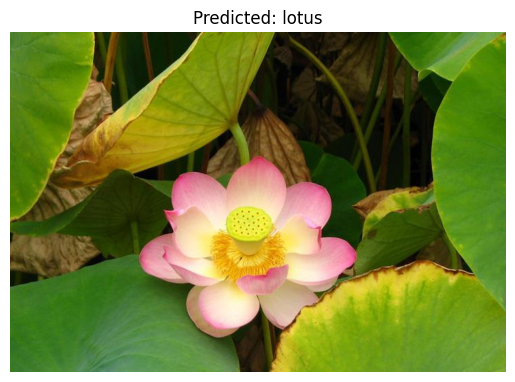

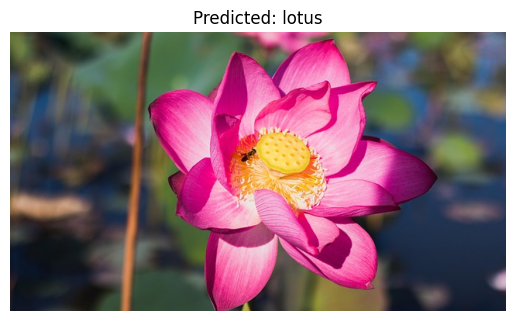

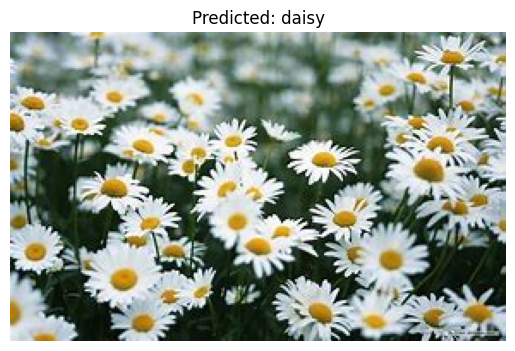

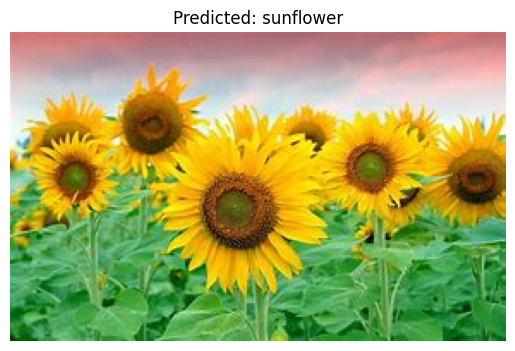

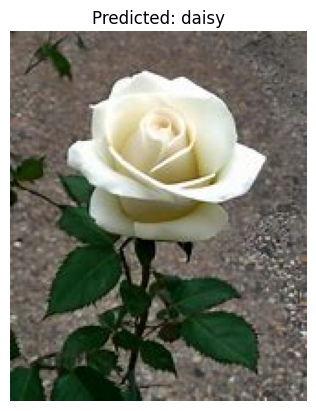

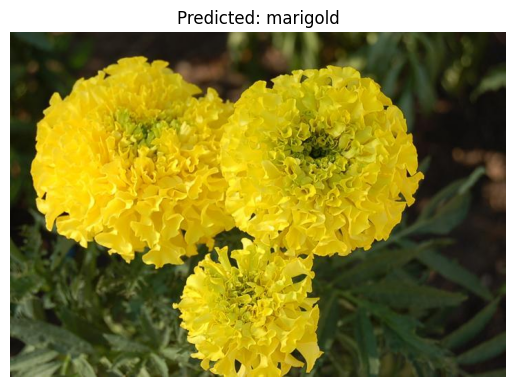

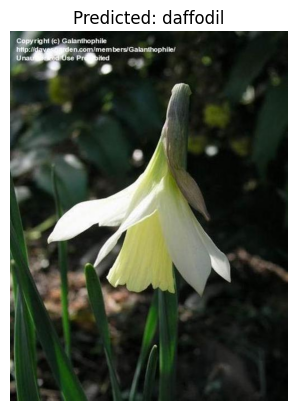

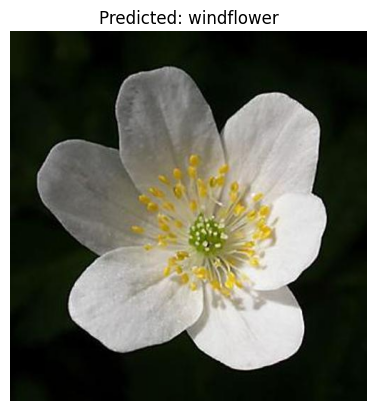

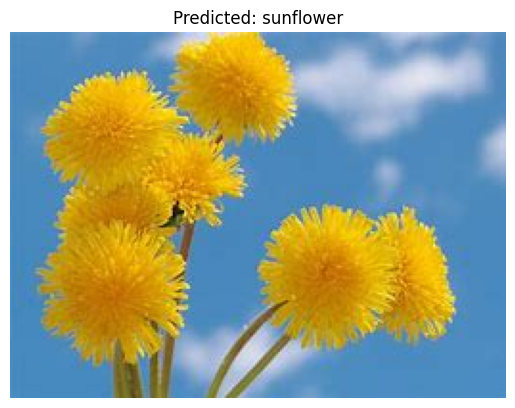

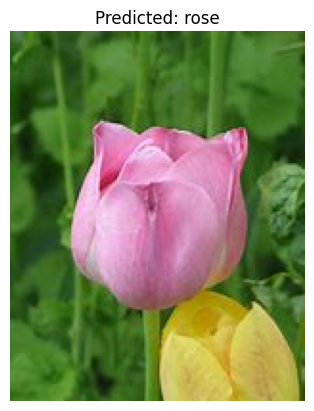

In [16]:
trained_model_path = get_versioned_model_path(latest=True)

model = load_model(trained_model_path, num_classes)
predict_image('./test_image.jpg', model, transform, class_names)
predict_images_in_folder('./test_flowers', model, transform, class_names)